# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Data filtering](#Data-filtering)
* [Visualization](#Visualization)
* [Discussion](#Discussion)

# Introduction

In this notebook, we consider whether dimensionality reduction might boost performance.

The results of two previous notebook sessions are combined and visualized. The results are discussed.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

time: 2.3 s


In [4]:
# Location of results .csv without dimenstionality reduction
CSV_FOLDER_ = "../8.0-mic-explore_neg-neu_hybrid"

# Location of tree results .csv without dimenstionality reduction
CSV_FOLDER_TREES = "../7.0-mic-explore_tree-based_models"

# Location of results .csv with dimenstionality reduction
CSV_FOLDER_DIMRED = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 121 ms


# Data loading

In [5]:
tree_df = pd.read_csv(f"{CSV_FOLDER_TREES}/explore_tree-based_models_results_CV5.csv")
tree_df.loc[:, "model_name"] = tree_df.loc[:, "model_name"].str.replace(
    "+", ",", regex=False
)

df = (
    pd.concat(
        [
            pd.read_csv(f"{CSV_FOLDER_}/explore_neg-neu_hybrid_results_CV5.csv"),
            pd.read_csv(
                f"{CSV_FOLDER_DIMRED}/explore_dimred_neg-neu_hybrid_results_CV5.csv"
            ),
            tree_df,
        ]
    )
    .drop(columns="Unnamed: 0")
    .fillna("")  # one of the tables has no dim_red column
)
del tree_df

df.loc[:, "model_name"] = df.loc[:, "model_name"].str.replace(
    "LogisticRegression", "LogReg"
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 0 to 12
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   avg_cv_fit_time           473 non-null    float64
 1   avg_cv_geometric_mean     473 non-null    float64
 2   avg_cv_f1                 473 non-null    float64
 3   avg_cv_predict_time       473 non-null    float64
 4   model_name                473 non-null    object 
 5   case                      473 non-null    object 
 6   avg_cv_balanced_accuracy  473 non-null    float64
 7   dim_red                   473 non-null    object 
dtypes: float64(5), object(3)
memory usage: 33.3+ KB


,avg_cv_fit_time,avg_cv_geometric_mean,avg_cv_f1,avg_cv_predict_time,model_name,case,avg_cv_balanced_accuracy,dim_red
0,0.001201,0.0,0.315900,0.001396,Dummy,negative,0.500000,
1,0.003518,0.0,0.220764,0.000196,Dummy,neutral,0.500000,
2,0.001553,0.0,0.204143,0.000200,Dummy,ternary,0.333333,
3,0.004719,0.0,0.072606,0.001592,Dummy+Dummy,ternary_negneu,0.333333,
4,18.250548,0.0,0.186268,0.122067,Dummy+LGBM,ternary_negneu,0.362928,


time: 57.8 ms


# Data filtering

In [6]:
# drop dummy classifiers
df = df.loc[~df.model_name.str.contains("Dummy")]
df.info()
assert len(df.loc[df.model_name.str.contains("Dummy")]) == 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 10 to 12
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   avg_cv_fit_time           390 non-null    float64
 1   avg_cv_geometric_mean     390 non-null    float64
 2   avg_cv_f1                 390 non-null    float64
 3   avg_cv_predict_time       390 non-null    float64
 4   model_name                390 non-null    object 
 5   case                      390 non-null    object 
 6   avg_cv_balanced_accuracy  390 non-null    float64
 7   dim_red                   390 non-null    object 
dtypes: float64(5), object(3)
memory usage: 27.4+ KB
time: 15 ms


In [7]:
print("base models considered:")
models = df.model_name
for _ in np.unique(models.loc[~models.str.contains("\+|,", regex=True)]):
    print(_)
del models

base models considered:
AdaBoost
Bagging
ExtraTrees
LDA
LGBM
LogReg
MLP
PassAgg
RandomForest
Ridge
SGD
SVC
XGB
time: 5 ms


# Visualization

To narrow the field, we will only consider the top 5 classifiers for each scoring metric per classification task. Three classification tasks are considered: negative/non-negative, neutral/non-neutral, and ternary (conflating ternary_negneu).

In [8]:
METRIC_NAMES = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_geometric_mean": "geometric mean",
    "avg_cv_predict_time": "predict time",
}


def plot_metric(metric: str, case: str, results_df: pd.DataFrame, top: int = 5) -> None:
    """Draw a barplot by classifier."""
    time_metric = "time" in metric
    results_df = (
        results_df.loc[results_df.case.str.contains(case)]
        .sort_values(by=metric, ascending=time_metric)
        .head(top)
    )
    results_df.loc[:, "model_name"] = results_df.loc[:, "dim_red"].str.cat(
        results_df.loc[:, "model_name"], sep="~"
    )

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(7)
    g.fig.set_figheight(3)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{case} {METRIC_NAMES[metric]}{' (s)' if time_metric else ''}",
        y=1,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 117 ms


Note that dimensionality reduction is represented by the symbols to the left of the '~'. Symbols to the right of '~' represent classifiers.

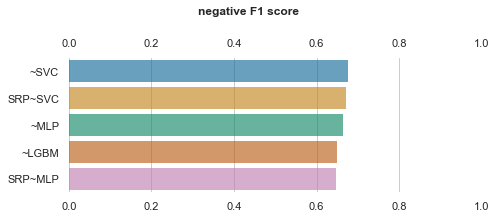

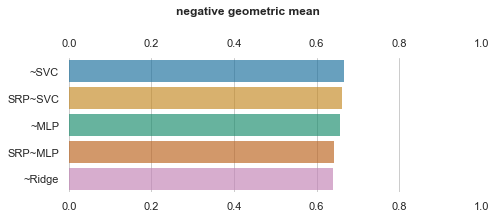

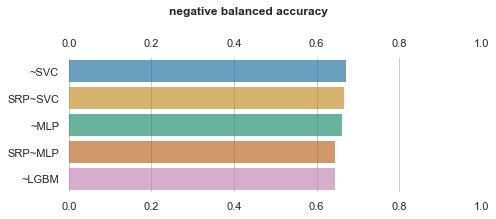

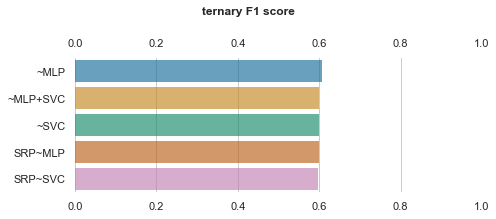

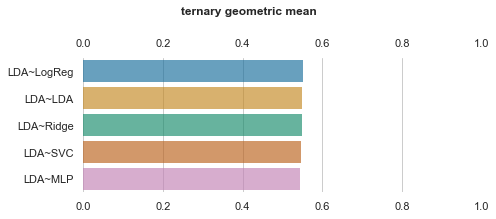

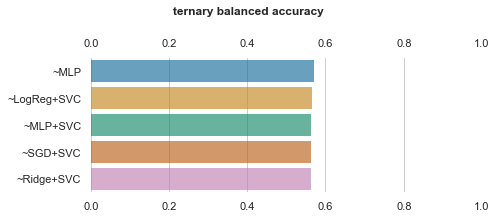

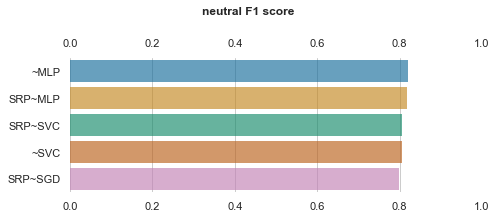

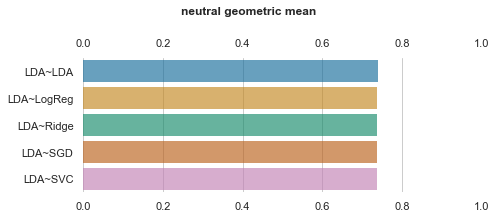

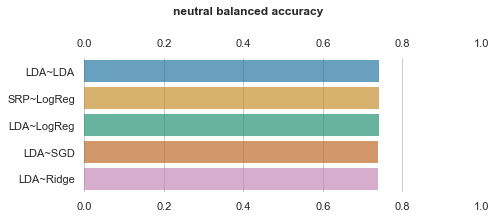

time: 4.26 s


In [9]:
for case in {"negative", "neutral", "ternary"}:
    for metric in {"avg_cv_balanced_accuracy", "avg_cv_f1", "avg_cv_geometric_mean"}:
        plot_metric(metric=metric, case=case, results_df=df)

Let's visualize the results again without MLP in the picture.

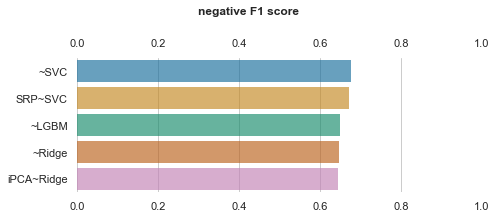

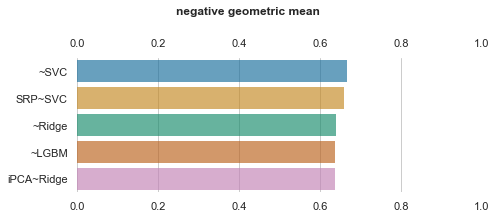

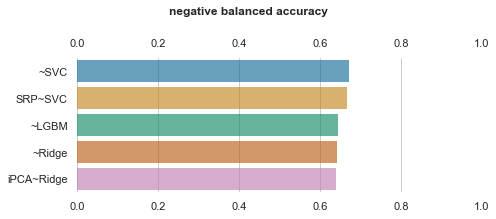

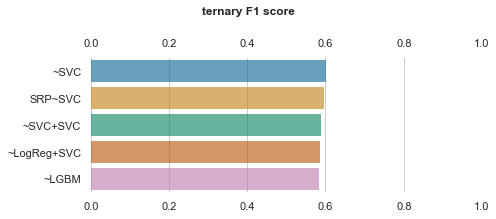

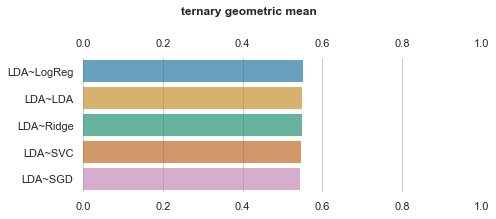

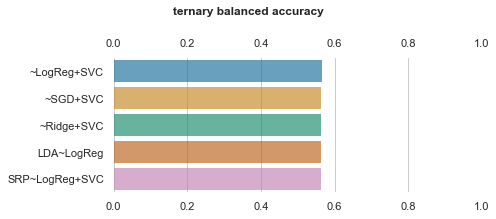

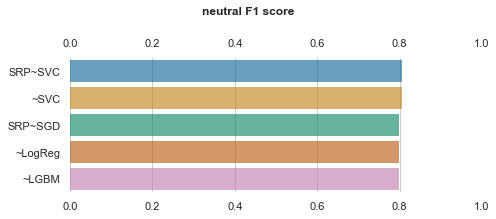

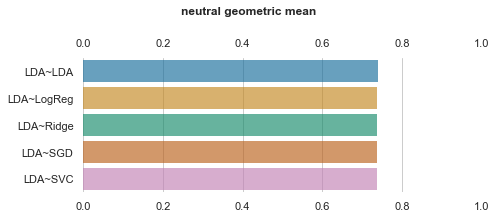

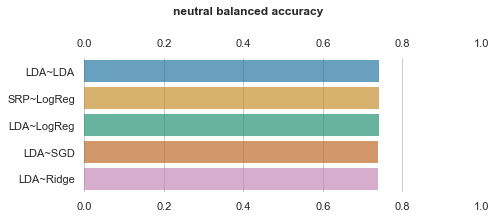

time: 5.74 s


In [10]:
for case in {"negative", "neutral", "ternary"}:
    for metric in {"avg_cv_balanced_accuracy", "avg_cv_f1", "avg_cv_geometric_mean"}:
        plot_metric(
            metric=metric,
            case=case,
            results_df=df.loc[~df.model_name.str.contains("MLP")],
        )

Let's look one more time but further filtering pipelines with features reduction.

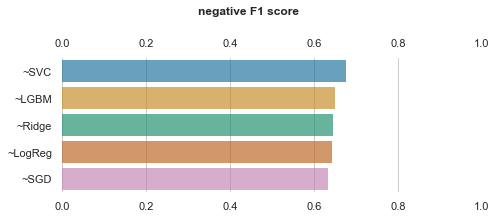

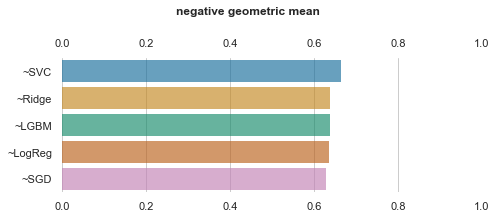

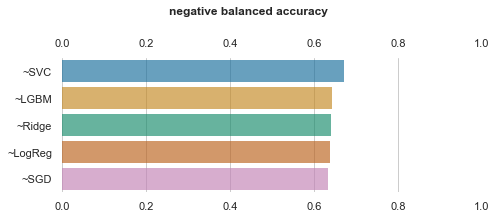

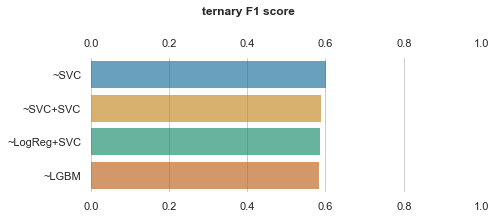

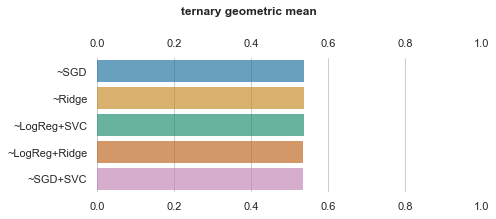

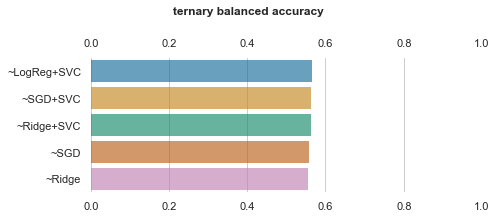

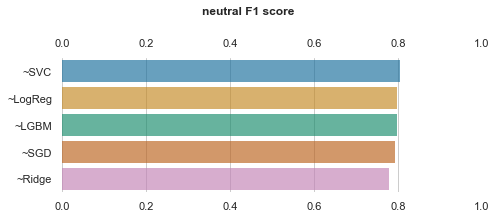

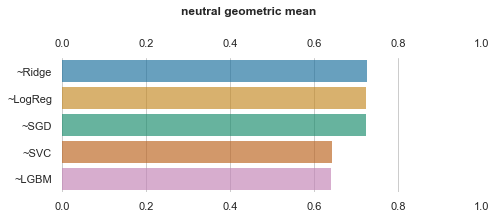

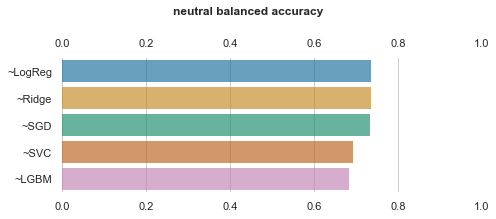

time: 3.55 s


In [11]:
for case in {"negative", "neutral", "ternary"}:
    for metric in {"avg_cv_balanced_accuracy", "avg_cv_f1", "avg_cv_geometric_mean"}:
        plot_metric(
            metric=metric,
            case=case,
            results_df=df.loc[~df.model_name.str.contains("MLP") & (df.dim_red == "")],
        )

A few base models keep showing up in the top. Let's look at their fit and predict times. We'll just look at the ternary cases since the rankings are additively composite and should be similar otherwise. Some models fit or predict faster with dimensionality reduction, so we will consider the observations without dimensionality reduction for now (this excludes some classifiers like LDA).

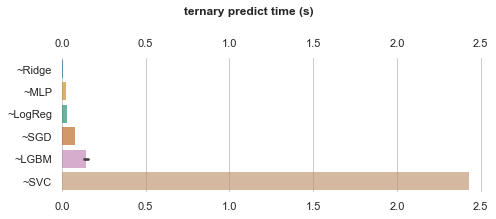

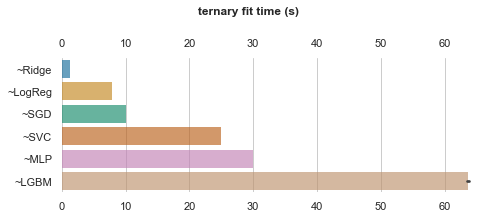

time: 1.05 s


In [12]:
top_base_models = {"LDA", "LGBM", "LogReg", "MLP", "Ridge", "SGD", "SVC"}
for metric in {"avg_cv_fit_time", "avg_cv_predict_time"}:
    plot_metric(
        metric,
        case="ternary",
        results_df=df.loc[df.model_name.isin(top_base_models) & (df.dim_red == "")],
        top=len(top_base_models) + 1,
    )

# Discussion

For next steps, we will test the following algorithms first:
* LinearDiscrimantAnalysis
* LogisticRegression
* RidgeClassifier
* SGDClassifier
* SVC

LGBM and MLP are tabled for now since they are both slow. We can keep the deep learning approach in our back pocket if the above are too limited in capacity.

SVC is slow too, but it may be the best classifier for negative/non-negative classification. At least it is faster than MLP and LGBM to train.

Dimensionality reduction will likely need to be tuned alongside hyperparameters.

In [13]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time:.1f} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 25.0 s
time: 130 ms


[^top](#Contents)